## import libraries

In [2]:
# import modules
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import matplotlib.lines as mlines

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

from scipy.stats import zscore
import contextily as cx

import rasterio as rio

In [3]:
#makes plot interactive
plt.ion()

# 1)  Social Indicator

Loads & clean data 

In [4]:
# loads the  data to calculate the social indicator from local machine
admin = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Stadtteile_Hamburg.shp")
stats = pd.read_csv("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/statistics_HH21.csv",encoding="utf-8", delimiter=";",decimal="." )
#admin.head()


In [5]:
#renames the columns to english
stats.columns = ['district','inhabitants', 'pop<18','%<18', 'pop>65y','%>65', 'foreignResidents', 'migration_backg', 'hh','pp_size','hh_kids', '%hh_kids','areakm2', 'pop_density','working_pop', '%working_pop', 'unemployed','%unemployed','unemployed<18','%unemployed<18', 'unemployed>65', '%unemployed>65','social_benefits', '%social_benefits','social_housing', '%social_housing']
#stats


In [6]:
#joins the population data with the shapefile of administrative boundaries and dropped unecessary columns in the admin dataset
admin_pop = pd.merge(admin,stats, left_on='stadtteil_', right_on='district', how = 'inner')

admin_pop.drop(columns=['OBJECTID','bezirk', 'stadttei_1', 'stadttei_2','pp_size', '%<18', 'hh','foreignResidents', 'migration_backg','pop<18','hh_kids', '%hh_kids', 'pop>65y', 'unemployed<18', ],axis=1, inplace=True)

#admin_pop

%unemployed          2.429636
%social_benefits     6.941654
%social_housing     10.981457
%unemployed>65       2.461121
dtype: float64

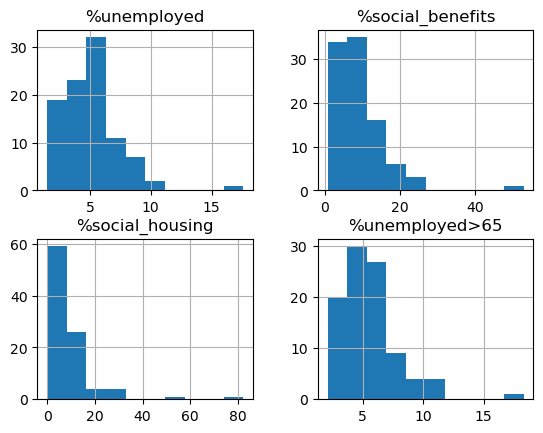

In [7]:
# this line of code first subsets the dataframe so that only numeric columns relevant to the further anylsis (social status) are maintained
# null values are droppped to enable calculation
social_stats = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65' ]].dropna()
#code then checks standard deviation 
social_stats.hist()
social_stats.std()

In [8]:
# The scipy Library in Python is used to calculate the z-score which helps to standardize the values for each column 

z_scores_admin_pop = social_stats[['%unemployed','%social_benefits','%social_housing','%unemployed>65']].apply(zscore)

print(z_scores_admin_pop.std()) # shows the std after calculation of z-score

%unemployed         1.005305
%social_benefits    1.005305
%social_housing     1.005305
%unemployed>65      1.005305
dtype: float64


#### Classification of social statistics layer

In [9]:
#groups & classifies the results into equal percentiles 
# Quantiles from 0-4 (e.g. 0= lowest 20th quantile of mean  to 4 = within highest 20th quantile))
#and saves the results to a new column. All the 4 indicators are equally weighted. 
z_scores_admin_pop['qt_soc_stats'] = pd.qcut(z_scores_admin_pop['%unemployed'] + z_scores_admin_pop['%social_benefits'] + z_scores_admin_pop['%social_housing'] + z_scores_admin_pop['%unemployed>65'], 5, labels=[0, 1, 2, 3, 4])


In [10]:
#The function adds a text column to the dataframe based on the classification into percentiles
#The function will be used for all of the different indicators)
def add_status_column(df, zscore_mean_column):
    df['status'] = ['very low' if x == 0 else  #creates the new column "status and then adds text description to the corresponding value"
                   'low' if x == 1 else
                   'medium' if x == 2 else
                   'high' if x == 3 else
                   'very high' for x in df[zscore_mean_column]]

# Applies the function to the data set based on the values in the stats column
add_status_column(z_scores_admin_pop, 'qt_soc_stats') 

In [11]:
z_scores_admin_pop.head() # checks if the operation has worked

,%unemployed,%social_benefits,%social_housing,%unemployed>65,qt_soc_stats,status
0,0.051394,-0.122718,0.355872,0.042137,3,high
1,-0.858895,-0.600631,1.500193,-1.183286,1,low
2,0.010018,-0.267540,0.374181,0.368917,3,high
3,1.085814,0.485535,0.291790,2.084510,4,very high
4,0.134148,-0.253058,0.429108,0.573154,3,high


In [12]:
#renames the newly calculated columns to differentiates from column from original dataset
z_scores_admin_pop.columns = ['%unemployed_z','%social_benefits_z', '%social_housing_z','%unemployed>65_z','qt_soc_stats', 'status']

In [13]:
#merges the social statistics  to the admin data frame to be able to plot the data later 
admin_socstats = pd.merge(admin_pop, z_scores_admin_pop, left_index=True, right_index=True) #Uses the index to perform the merge operation
#drops the column with the "old statistics"
admin_socstats.drop(columns=['%unemployed','%social_benefits','%social_housing','%unemployed>65'])
admin_socstats.head()

,bezirk_nam,stadtteil_,SHAPE_Leng,SHAPE_Area,geometry,district,inhabitants,%>65,areakm2,pop_density,...,social_benefits,%social_benefits,social_housing,%social_housing,%unemployed_z,%social_benefits_z,%social_housing_z,%unemployed>65_z,qt_soc_stats,status
0,Hamburg-Mitte,Hamburg-Altstadt,9028.180532,3.676562e+06,"POLYGON ((1113865.821 7085107.333, 1113978.324...",Hamburg-Altstadt,2358,10.9,1.3,1.813.00,...,193,8.2,176,12.4,0.051394,-0.122718,0.355872,0.042137,3,high
1,Hamburg-Mitte,HafenCity,13902.691334,6.860720e+06,"POLYGON ((1113043.882 7082944.386, 1112901.932...",HafenCity,6302,9.5,2.4,2.598.00,...,309,4.9,799,24.9,-0.858895,-0.600631,1.500193,-1.183286,1,low
2,Hamburg-Mitte,Neustadt,11133.923114,6.395226e+06,"POLYGON ((1112508.476 7085835.161, 1112319.283...",Neustadt,12611,15.0,2.3,5.575.00,...,911,7.2,967,12.6,0.010018,-0.267540,0.374181,0.368917,3,high
3,Hamburg-Mitte,St. Pauli,15968.675123,6.343533e+06,"POLYGON ((1109116.549 7084327.397, 1109001.027...",St. Pauli,21803,10.3,2.2,9.723.00,...,2.708.00,12.4,1.485.00,11.7,1.085814,0.485535,0.291790,2.084510,4,very high
4,Hamburg-Mitte,St. Georg,9795.650670,5.155061e+06,"POLYGON ((1114563.830 7085359.663, 1114541.839...",St. Georg,11467,14.0,1.8,6.291.00,...,841,7.3,852,13.2,0.134148,-0.253058,0.429108,0.573154,3,high


# 2) Environmental Indicators
Uses noise, green areas, surface temperature? as environmental indicator)

In [14]:
#loads the data for analysis of environmental indicators
noise = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Laermkarten_HH_2018-11-19.shp")
buildings = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Gebaeude_Hamburg.shp")
green_areas = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Oeffentliche_Gruenanlage_Hamburg.shp")

In [15]:
# the function checks the crs of different layers and reprojects them to the target EPSG for Hamburg, GE(25832) for spatial operations
def reproject_to_local_epsg(gdf):
    # Checks the CRS of the input GeoDataFrame
    print('Original CRS:', gdf.crs)

    # Reprojects the GeoDataFrame to EPSG 25832
    gdf_reproj = gdf.to_crs(epsg=25832)

    # Prints out the CRS of the output GeoDataFrame
    print('Reprojected CRS:', gdf_reproj.crs)

    return gdf_reproj

# applies function to all the data  to convert CRS
admin_pop_reproj = reproject_to_local_epsg(admin_pop)
noise_reproj = reproject_to_local_epsg(noise)
housing_reproj = reproject_to_local_epsg(buildings)
green_areas_reproj = reproject_to_local_epsg(green_areas)


Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:25832
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832


## a)  Green areas - access to and distribution
Analyses distribution of green areas per district and area / inhabitant

In [16]:
#green_areas_reproj.columns

In [17]:
#deletes the values with code 10 = playground according to ALKIS key(official cadastre information system
green_areas_reproj = green_areas_reproj[green_areas_reproj.nutzung != 10]

#drops unimportant columns from the dataset
green_areas_reproj.drop(columns=['veroeffent', 'nutzung', 'nutz_code' ,'herrichtun', 'gesamtanla','aktualitae','idnr','belegenh_1','belegenhei','quelle_dat', 'stand'],axis=1, inplace=True)

green_areas_reproj.head()

,OBJECTID,dgpkey,benennung,gesamtan_1,bezirk,stadtteil,ortsteil,gemarkung,verwaltung,flaeche_ha,flaeche_qm,SHAPE_Leng,SHAPE_Area,geometry
0,1,51580005,NaN,Schutz-Straßenbegleitgrün Rev 3,Wandsbek,Bramfeld,515,546,Stadtgrün,1.3090,13090,1813.268251,37135.153073,"POLYGON ((571682.385 5940442.628, 571927.493 5..."
1,2,51550113,NaN,Osterbekoberlauf,Wandsbek,Bramfeld,515,546,Stadtgrün,0.4478,4478,920.409622,12697.549886,"POLYGON ((572254.058 5939481.930, 572254.220 5..."
2,3,52650280,NaN,Stellau Grün,Wandsbek,Rahlstedt,526,544,Stadtgrün,0.2839,2839,637.414887,8047.566252,"POLYGON ((577689.808 5938869.601, 577701.406 5..."
3,4,52650280,NaN,Stellau Grün,Wandsbek,Rahlstedt,526,544,Stadtgrün,0.0746,746,185.305657,2116.281875,"POLYGON ((577695.717 5938789.061, 577671.599 5..."
4,5,50950039,NaN,Gartenstadt,Wandsbek,Wandsbek,509,552,AGV,0.0356,356,252.935327,1008.046963,"POLYGON ((571054.670 5938638.040, 571054.878 5..."


#### Calculation of statistics of green areas at district level

In [18]:
# Calculates the sum of the area  statistics for the green areas per district (district = stadtteil)
green_area_sum = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].sum().reset_index() # groups the dataset
green_area_sum.rename(columns={'flaeche_ha': 'green_area_total_ha'}, inplace=True) # renames the columns

# Calculates mean green space area per district
green_area_mean = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].mean().reset_index() 
green_area_mean.rename(columns={'flaeche_ha': 'green_area_mean_ha'}, inplace=True)

# Calculates the count of green spaces per district=  "Bennenung" = unique name of green area
green_space_count = green_areas_reproj.groupby(['stadtteil'])['benennung'].count().reset_index()
green_space_count.rename(columns={'benennung': 'green_space_count'}, inplace=True)

# Combines the statistics into one data frame using the stadtteil column
green_stats = pd.merge(green_area_sum, green_area_mean, on='stadtteil')
green_stats = pd.merge(green_stats, green_space_count, on='stadtteil')


In [19]:
# Calculates the percentage of green space from total area of the district
green_stats['perc_green_area'] = green_areas_reproj['flaeche_ha'] / green_areas_reproj['geometry'].area * 100
#green_stats.head()

In [20]:
# Finally calculates the area per inhabitant by using the column inhabitants from the admin_pop_reproj dataframe
# adds the column to the green_stats data frame
green_stats = green_stats.merge(admin_pop_reproj[['stadtteil_', 'inhabitants']], left_on='stadtteil', right_on='stadtteil_', how='left')
green_stats.drop('stadtteil_', axis=1, inplace=True)

In [21]:
#calculates the area / inhabitant and saves the results in a new column
green_stats['area_per_inhbt'] = green_stats['inhabitants'] / green_stats['green_area_total_ha']
green_stats.head()

,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,perc_green_area,inhabitants,area_per_inhbt
0,Allermöhe,41.4007,3.450058,7,0.010000,1441.0,34.806175
1,Alsterdorf,13.6286,0.592548,6,0.010001,14975.0,1098.792246
2,Altengamme,0.2130,0.213000,0,0.010002,2319.0,10887.323944
3,Altona-Altstadt,28.3002,0.496495,37,0.009993,29151.0,1030.063392
4,Altona-Nord,8.0044,0.470847,1,0.010012,25942.0,3240.967468


In [22]:
#checks std of relevant values
green_stats[['area_per_inhbt','perc_green_area' ]].std()

area_per_inhbt     2488.762957
perc_green_area       0.000002
dtype: float64

In [23]:
#first null values will be dropped to enable zscore 
green_stats = green_stats.dropna(subset=['area_per_inhbt'])

#computes the z-score for the variables used for calculation from the  greenstats data set 
z_scores_green_stats = green_stats[['area_per_inhbt','perc_green_area' ]].apply(zscore)
#renames the column tonot confuse it with the original columns in thre green_stats data set
z_scores_green_stats = z_scores_green_stats.rename(columns={'area_per_inhbt': 'z_area_per_inhbt', 'perc_green_area': 'z_perc_green_area'})
#checks the std after the z-score has been applied
z_scores_green_stats[['z_area_per_inhbt','z_perc_green_area' ]].std()

z_area_per_inhbt     1.005195
z_perc_green_area    1.005195
dtype: float64

In [24]:
z_scores_green_stats.head()

,z_area_per_inhbt,z_perc_green_area
0,-0.605055,0.300347
1,-0.175318,0.540807
2,3.778205,0.870562
3,-0.203077,-2.750660
4,0.689892,5.351962


In [25]:
# Concatenates the original DataFrame with the z-score DataFrame
green_stats_zscore = pd.concat([green_stats, z_scores_green_stats], axis=1)
# drops the original variables perc_green_area and _area_per_inhb
green_stats_zscore = green_stats_zscore.drop(['area_per_inhbt', 'perc_green_area'], axis=1)

# Views the resulting DataFrame
green_stats_zscore.head()

,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,inhabitants,z_area_per_inhbt,z_perc_green_area
0,Allermöhe,41.4007,3.450058,7,1441.0,-0.605055,0.300347
1,Alsterdorf,13.6286,0.592548,6,14975.0,-0.175318,0.540807
2,Altengamme,0.2130,0.213000,0,2319.0,3.778205,0.870562
3,Altona-Altstadt,28.3002,0.496495,37,29151.0,-0.203077,-2.750660
4,Altona-Nord,8.0044,0.470847,1,25942.0,0.689892,5.351962


#### Classification of green area layer

In [26]:
# the function classifies the statistics into 5 equal percentiles. The function will be used for all the environmental variables 
# uses the same approach as for the social indicator: quantiles 0-4 (e.g. 0= lowest 20th quantile of mean / to  - 4 within highest 20th quantile)
def percentile_5(gpd, col_name, percentiles): 
    #defines the name of the new column to save the results , then classifies the dataset into 5 equal percentiles 0-4
    gpd[col_name + '_percentile']  = pd.qcut(gpd[col_name], percentiles, labels=[0, 1, 2, 3, 4]) # col_name= column used for classification

    return gpd

In [27]:
#applies the function to classify the green_stats data into equal percentiles based on 'area_per_inhbt' column
percentile_5(green_stats_zscore, 'z_area_per_inhbt',5)

,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,inhabitants,z_area_per_inhbt,z_perc_green_area,z_area_per_inhbt_percentile
0,Allermöhe,41.4007,3.450058,7,1441.0,-0.605055,0.300347,0
1,Alsterdorf,13.6286,0.592548,6,14975.0,-0.175318,0.540807,3
2,Altengamme,0.2130,0.213000,0,2319.0,3.778205,0.870562,4
3,Altona-Altstadt,28.3002,0.496495,37,29151.0,-0.203077,-2.750660,3
4,Altona-Nord,8.0044,0.470847,1,25942.0,0.689892,5.351962,4
...,...,...,...,...,...,...,...,...
95,Wellingsbüttel,36.6228,2.288925,2,11014.0,-0.497645,0.121736,0
96,Wilhelmsburg,141.8108,0.864700,105,52683.0,-0.469066,0.140792,1
97,Wilstorf,55.9543,1.929459,13,17436.0,-0.493255,0.077308,0
98,Winterhude,162.3162,1.575885,52,56878.0,-0.477583,0.139549,1


In [28]:
# applies the add status column function defined earlier based on the classified "percentile column"
add_status_column(green_stats_zscore, 'z_area_per_inhbt_percentile')
green_stats.head()



,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,perc_green_area,inhabitants,area_per_inhbt
0,Allermöhe,41.4007,3.450058,7,0.010000,1441.0,34.806175
1,Alsterdorf,13.6286,0.592548,6,0.010001,14975.0,1098.792246
2,Altengamme,0.2130,0.213000,0,0.010002,2319.0,10887.323944
3,Altona-Altstadt,28.3002,0.496495,37,0.009993,29151.0,1030.063392
4,Altona-Nord,8.0044,0.470847,1,0.010012,25942.0,3240.967468


In [29]:
#merges the green statistics computed to the reprojected admin data frame to be able to plot the data later on
admin_greenstats = pd.merge(admin_pop_reproj, green_stats_zscore, left_index=True, right_index=True)
admin_greenstats.head()

,bezirk_nam,stadtteil_,SHAPE_Leng,SHAPE_Area,geometry,district,inhabitants_x,%>65,areakm2,pop_density,...,%social_housing,stadtteil,green_area_total_ha,green_area_mean_ha,green_space_count,inhabitants_y,z_area_per_inhbt,z_perc_green_area,z_area_per_inhbt_percentile,status
0,Hamburg-Mitte,Hamburg-Altstadt,9028.180532,3.676562e+06,"POLYGON ((566655.103 5933760.301, 566722.625 5...",Hamburg-Altstadt,2358,10.9,1.3,1.813.00,...,12.4,Allermöhe,41.4007,3.450058,7,1441.0,-0.605055,0.300347,0,very low
1,Hamburg-Mitte,HafenCity,13902.691334,6.860720e+06,"POLYGON ((566183.919 5932468.981, 566099.304 5...",HafenCity,6302,9.5,2.4,2.598.00,...,24.9,Alsterdorf,13.6286,0.592548,6,14975.0,-0.175318,0.540807,3,high
2,Hamburg-Mitte,Neustadt,11133.923114,6.395226e+06,"POLYGON ((565841.224 5934181.092, 565729.797 5...",Neustadt,12611,15.0,2.3,5.575.00,...,12.6,Altengamme,0.2130,0.213000,0,2319.0,3.778205,0.870562,4,very high
3,Hamburg-Mitte,St. Pauli,15968.675123,6.343533e+06,"POLYGON ((563834.747 5933258.107, 563765.973 5...",St. Pauli,21803,10.3,2.2,9.723.00,...,11.7,Altona-Altstadt,28.3002,0.496495,37,29151.0,-0.203077,-2.750660,3,high
4,Hamburg-Mitte,St. Georg,9795.650670,5.155061e+06,"POLYGON ((567068.406 5933916.007, 567055.305 5...",St. Georg,11467,14.0,1.8,6.291.00,...,13.2,Altona-Nord,8.0044,0.470847,1,25942.0,0.689892,5.351962,4,very high


In [30]:
#admin_greenstats.columns

## b) Noise Pollution 
For the noise indicator the assessment aims to identify the area of houses affected by noise and noiseclass /  district  

Analysis, filter and cleaning of the Housing Dataset

In [31]:
#housing_reproj.columns
#checks data type of column gebaeudefu which indicates usage of houses 
housing_reproj['gebaeudefu'] = housing_reproj['gebaeudefu'].astype(int)# converts the column to integer to enable calculations

#drops uninmportant columns in the dataset
housing_reproj.drop(columns=['anzahlDerU', 'lageZurErd', 'dachart', 'SHAPE_Leng'],axis=1, inplace=True)


In [32]:
# filters out any non-residential housing from the data set and keeps only residential buildings ALKIS Keys (1000 and 1010 )
housing_reproj = housing_reproj[(housing_reproj['gebaeudefu'] == 1010) | (housing_reproj['gebaeudefu'] == 1000)]
#housing_reproj.head()

Analysis, filter and cleaning of the Noise Dataset

In [33]:
###checks out the noise data set, which is a classified shapefile:name here stands for severity of noise from 0 low to 4 highest
noise_reproj.head()  

,klasse,gml_id,name,geometry
0,&gt;50 - 55 dB(A),APP_STRASSENVERKEHR_NACHT_2017_1,0,"POLYGON ((565325.000 5918845.000, 565315.000 5..."
1,&gt;50 - 55 dB(A),APP_STRASSENVERKEHR_NACHT_2017_2,0,"POLYGON ((565255.000 5918885.000, 565255.000 5..."
2,&gt;50 - 55 dB(A),APP_STRASSENVERKEHR_NACHT_2017_3,0,"POLYGON ((565335.000 5918895.000, 565335.000 5..."
3,&gt;50 - 55 dB(A),APP_STRASSENVERKEHR_NACHT_2017_4,0,"POLYGON ((565305.000 5919025.000, 565305.000 5..."
4,&gt;50 - 55 dB(A),APP_STRASSENVERKEHR_NACHT_2017_5,0,"POLYGON ((565295.000 5919065.000, 565285.000 5..."


Joins the Housing Data set to the Noise Data set

In [34]:
# the code uses the geopandas overlay method and interesect operation to determine where the noise layer intersects with the house layer 
houses_noise = gpd.overlay(housing_reproj, noise_reproj, how='intersection')

In [35]:
#renames column names to noiseclass and anzahDerO to English = number of floors and grundflaec to house_area
houses_noise = houses_noise.rename(columns={'name': 'noiseclass', 'anzahlDerO': 'floors', 'grundflaec':'house_area'})

In [36]:
# joins the data frame to the admin dataset to be able to plot the data later
admin_noisestats = gpd.sjoin(admin_pop_reproj, houses_noise)

In [37]:
#admin_noisestats.columns

#### Calculation of Statistics

In [38]:
#groups the dataset to get the number of houses per noiseclass and district
houses_noiseclass = admin_noisestats.groupby(['district', 'noiseclass'])['OBJECTID'].count().reset_index()
houses_noiseclass.head()

,district,noiseclass,OBJECTID
0,Allermöhe,0,135
1,Allermöhe,1,281
2,Allermöhe,2,120
3,Allermöhe,3,25
4,Allermöhe,4,1


In [39]:
# mulitplies the number of houses with the house area 
admin_noisestats['total_area'] = admin_noisestats['OBJECTID'] * admin_noisestats['house_area']

In [40]:
# multiplies the house area with the number of floors to get the total affected residential housing area by noiseclass
#convert it to sqkm
admin_noisestats['area_floors']=admin_noisestats['total_area']*admin_noisestats['floors'].astype(int)/1000000

In [41]:
#admin_noisestats['total_area_floors'].hist()
#admin_noisestats.head()

In [42]:
# converts the noiseclass to an integer
admin_noisestats['noiseclass'] = admin_noisestats['noiseclass'].astype(int)

In [43]:
#weights the area by noiseclass in view of severity from low to high (increase by 0.5)
weights = {0: 0.5, 1: 1, 2: 1.5, 3: 2, 4: 2.5} # dictionary to define the weights
#applies the weights and saves the results in a new column
#uses  the pandas.map function to assign the weights
admin_noisestats['weighted_area'] = admin_noisestats['area_floors'] * admin_noisestats['noiseclass'].map(weights) 

In [44]:
#groups data set by district and weighted area
noisestats_weighted = admin_noisestats.groupby('district')['weighted_area'].sum().reset_index()
#admin_noisestats.head() # recommended to not display the output due to its size

In [47]:
#applies function thats classifies dataframe   into percentiles
percentile_5(noisestats_weighted, 'weighted_area',5)

In [48]:
# applies the add status column function defined earlier
add_status_column(noisestats_weighted, 'weighted_area_percentile')
noisestats_weighted.head()

In [49]:
#merges the grouped data set with the weighted area with the orignial merged noisedata to prepare for plotting
noisestats_merged = pd.merge(noisestats_weighted, admin_pop_reproj, left_on='district', right_on='district', how='inner')

In [ ]:
#checks if the merge has worked
#noisestats_merged.head()

## Visualizations of Indicators
Create maps and plots for the different indicators

Saves the dataframes with the calculations in csv format to output folder in GITHB

In [ ]:
#saves the final data frames as csv file into the ouptut folder on Github                                                                   
#admin_socstats.to_csv("./output/social_stats.csv")
#noisestats_merged.to_csv("./output/noise_stats.csv")
#admin_greenstats.to_csv("./output/green_stats.csv")

In [ ]:
# function to define parameters for mapping of indicators
def plot_stats(gdf, title, color): # defines the parameterrs that need to be adapted for the individual plots
    
    #  defines order of the status lassification
    status_order = ['very low', 'low', 'medium', 'high', 'very high']

    # convert the status column to a categorical variable with the defined order
    gdf['status'] = pd.Categorical(gdf['status'], categories=status_order, ordered=True) # from low to high

    # sorts the gvalues
    gdf = gdf.sort_values('status')
    
    # Creates a figure and defines the size of it
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plots the data using the the status column
    gdf.plot("status", cmap=color, legend=True, ax=ax) # shows the legend
    
    legend = ax.get_legend()
    legend.set_title("Status") # adds the legend title

    # Sets the title of the plot
    ax.set_title(title,fontweight="bold")
    
    cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite)

    #adds the district name to the plot and defines some style parameters
    gdf.apply(lambda x: ax.annotate(text=x['district'], xy=x.geometry.centroid.coords[0], ha='center', color="grey", size=7), axis=1)

    ax.set_axis_off()
    

    
    # Displays the plot
    plt.show()

In [ ]:
## applies the function to the individual indicators created 
plot_stats(admin_socstats,"Indicator Social Status - Classified by percentile ", "Oranges")

In [ ]:
plot_stats(admin_greenstats, "Indicator Access to Green Areas - Classified by percentile", "YlGn")

In [ ]:
plot_stats(noisestats_merged, "Indicator Noise Pollution - Classified by percentile ", "Blues")

In [ ]:
# merge operation of  statistics dataframes by only keeping relevant columns
#subsets the social stats dataset to keep only relevant columns for merge
soc_subset = admin_socstats[["bezirk_nam","district","geometry", "status","qt_soc_stats", "%unemployed","%social_benefits","%social_housing"]]

#renames status columns in all dataframes to avoid duplications and adds identifier
soc_subset=soc_subset.rename(columns={"status":"status_soc"})
green_subset=green_stats_zscore.rename(columns={"status":"status_greens"})
noisestats_merged=noisestats_merged.rename(columns={"status":"status_noise"})
#noisestats_subset.drop(columns=['geometry'])

In [ ]:
#merges the statistics data set to have one single dataframe for creation of plots 
stats_merged = green_subset.merge(soc_subset, left_on='stadtteil', right_on='district', how='inner')

stats_merged = stats_merged.merge(noisestats_merged, left_on='district', right_on='district', how='right')


In [ ]:
stats_merged.head()
stats_merged.to_csv("./output/stats_merged.csv")

In [ ]:
# only selects the classified status indicators into 1 data set. This will be used to show the distribution of the values 
stat_indicators=stats_merged[['bezirk_nam', 'district','weighted_area_percentile','qt_soc_stats','z_area_per_inhbt','status_soc','status_greens','status_noise']]

In [ ]:
stat_indicators.head()

##### 